<a href="https://colab.research.google.com/github/AprilWuWu/AI-Portfolio/blob/main/transfer(%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
f = zipfile.ZipFile('/content/drive/My Drive/AI/深度學習/train.zip')
f.extractall('data')

In [ ]:
!ls data/train

串流輸出內容已截斷至最後 5000 行。
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.5512.jpg
cat.10012.jpg  cat.3263.jpg  cat.7764.jpg   

In [ ]:
import glob
import pandas as pd
dogs = glob.glob('data/train/dog.*')
cats = glob.glob('data/train/cat.*')

df = pd.DataFrame({
    'path': dogs + cats,
    'ans': [0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,data/train/dog.5656.jpg,0
1,data/train/dog.8713.jpg,0
2,data/train/dog.6643.jpg,0
3,data/train/dog.5301.jpg,0
4,data/train/dog.2056.jpg,0
...,...,...
24995,data/train/cat.5152.jpg,1
24996,data/train/cat.3089.jpg,1
24997,data/train/cat.9365.jpg,1
24998,data/train/cat.4735.jpg,1


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

cnn_vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# cnn_vgg.summary()


# cnn_rest = ResNet101(include_top=False, input_shape=(224, 224, 3))
# cnn_rest.summary()
# cnn.layers

for layer in cnn_vgg.layers:
  layer.trainable = False
mlp = [
 # 512 * 4 = 2048(一半訓練[後來平均， 後來標準差]， 一半不訓練[[原本平均, 標準差]])
 BatchNormalization(),
 Flatten(),
 Dense(256, activation='relu'),  
 Dropout(0.25),
 Dense(2, activation="softmax")    
]

vgg_model = Sequential(cnn_vgg.layers + mlp)
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
vgg_model.compile(loss=SparseCategoricalCrossentropy(),
         optimizer="adam",
         metrics=['accuracy'])


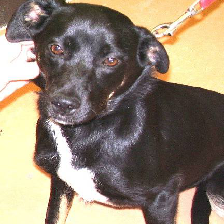

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
img = load_img(df['path'][0], target_size=(224, 224))
img

In [ ]:
from sklearn.model_selection import train_test_split

import numpy as np
# 只要開始處理，就不要用dataframe,改用np.array
x = np.array(df['path'])
y = np.array(df['ans'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_data(x, y, batch=20):
  idx = np.random.randint(0, len(x), batch)
  x_idx, y_idx = x[idx], y[idx]
  x_ori, x_norm, y_ori = [], [], y_idx
  for p in x_idx:
    img = np.array(load_img(p, target_size=(224, 224)))
    img_pre = preprocess_input(img)
    x_ori.append(img)
    x_norm.append(img_pre)
  return np.array(x_ori), np.array(x_norm), np.array(y_ori)

# get_data(x_train, y_train, 1)

In [ ]:
for i in range(10):
  print("[Times]:", i)
  _, x_batch, y_batch = get_data(x_train, y_train)
  result = vgg_model.train_on_batch(x_batch, y_batch)
  print('[Train]:', result)
  _, x_batch, y_batch = get_data(x_test, y_test, 200)
  result = vgg_model.test_on_batch(x_batch, y_batch)
  print('[Test]:', result)

[Times]: 0
[Train]: [0.014470860362052917, 1.0]
[Test]: [0.9645298719406128, 0.9700000286102295]
[Times]: 1
[Train]: [0.3077983260154724, 0.949999988079071]
[Test]: [1.435390591621399, 0.9399999976158142]
[Times]: 2
[Train]: [3.3496594429016113, 0.8500000238418579]
[Test]: [0.8537160754203796, 0.9649999737739563]
[Times]: 3
[Train]: [0.0007920850766822696, 1.0]
[Test]: [1.3658874034881592, 0.9649999737739563]
[Times]: 4
[Train]: [0.5285782814025879, 0.8999999761581421]
[Test]: [0.6836248636245728, 0.9649999737739563]
[Times]: 5
[Train]: [0.41492635011672974, 0.8999999761581421]
[Test]: [0.6383410692214966, 0.9750000238418579]
[Times]: 6
[Train]: [0.006001283414661884, 1.0]
[Test]: [1.5967427492141724, 0.9399999976158142]
[Times]: 7
[Train]: [0.08708924055099487, 1.0]
[Test]: [0.9425127506256104, 0.9599999785423279]
[Times]: 8
[Train]: [3.7729150790255517e-06, 1.0]
[Test]: [1.7242311239242554, 0.9399999976158142]
[Times]: 9
[Train]: [0.02992820367217064, 1.0]
[Test]: [1.2024126052856445

In [ ]:
vgg_model.predict(x_batch)

In [ ]:
x_ori, x_batch, y_batch = get_data(x_test,y_test, 1000)
vgg_model.evaluate(x_batch, y_batch)

32/32 [==============================] - 4s 113ms/step - loss: 1.0379 - accuracy: 0.9520


[1.0378830432891846, 0.9520000219345093]

In [ ]:
# 找最大值的index
pre = vgg_model.predict(x_batch).argmax(axis=-1)

In [ ]:
trans = ['dog', 'cat']

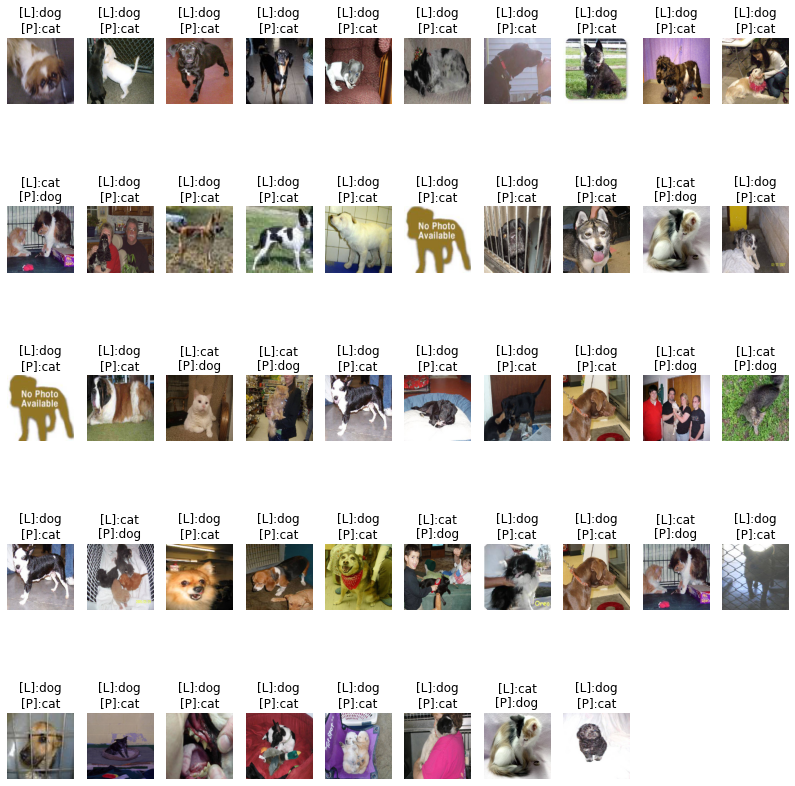

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 畫布寬高
plt.figure(figsize=(14, 15))

# 找到非0值的位置，他可以比較多維度
idx = np.nonzero(pre != y_batch)[0][:200]
width = 10
height = len(idx) // width + 1

for i, d in enumerate(idx):
  img, label, p = x_ori[d], y_batch[d], pre[d]
  t = f'[L]:{trans[int(label)]}\n[P]:{trans[int(p)]}'
  plt.subplot(height, width, i+1)
  plt.title(t)
  plt.axis('off')
  plt.imshow(img)

# VGG

# RestNet